The goal of this notebook is to estimate how many posterior samples we need to get a reliable estimate of the population.  We use some preliminary samples from the 1-year chains to get an idea of how uncertain the parameter estimates might be.  Then we re-weight the existing flat-prior samples according to the population, and re-sample.  On re-sampling, we want to have a sufficient number of samples to properly explore the posterior (certainly $\gg 1$, say at least 10, but hopefully more).

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
import model
import theano.tensor as tt
from scipy.interpolate import interp1d
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

We load the observations and posterior samples (flat prior).

In [3]:
with h5py.File('observations.h5', 'r') as f:
    z = array(f['zs'])
    m1s = array(f['posteriors']['m1det'])
    m2s = array(f['posteriors']['m2det'])
    dls = array(f['posteriors']['dl'])

This code is copied from `PISNAnalysis.ipynb`

In [4]:
def load_chains(f, selector=None):
    names = ['H0', 'Om', 'w', 'R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma', 'sigma_low', 'sigma_high', 'Nex', 'neff_det']
    
    if selector is None:
        selector = slice(None)
    
    c = {}
    with h5py.File(f, 'r') as inp:
        nobs = inp.attrs['nobs']
        for n in names:
            c[n] = array(inp[n])[selector, ...]

    mu_term = nobs*(log(c['Nex'])-log(c['R0']))
    sigma_term = nobs**2/(2*c['neff_det'])
    
    R0_dsigma_term = (1 - 4*nobs + 3*nobs**2)/c['neff_det']
    R0_sigma_term = nobs-1
    
    print('Fractional bias in parameter estimates due to selection uncertainty is {:.2f}'.format(std(sigma_term)/std(mu_term)))
    print('Fractional bias in R0 is {:.2f}'.format(mean(nobs/c['neff_det'])))
    print('Fracitonal expansion in sigma_R0 is {:.2f}'.format(mean(R0_dsigma_term/(2*R0_sigma_term))))
    return c

Here we re-weight the samples according to the population distribution described by a random parameter sample from the chain:

In [5]:
def reweighted_samples(chain, m1s, m2s, dls):
    c = chain
    
    i = random.choice(len(c['H0']))
    
    dH = 4.42563416002 * (67.74/c['H0'][i])
    
    zs_interp = linspace(0, 10, 1000)
    dls_interp = model.dls_of_zs(zs_interp, dH, c['Om'][i], c['w'][i]).eval()
    
    z_f = interp1d(dls_interp, zs_interp)
    zs = z_f(dls)

    samples = []
    
    ms_interp = exp(arange(log(1), log(200), 0.01))
    
    log_wts = model.log_dNdm1dm2ddLdt(m1s/(1+zs), m2s/(1+zs), dls, zs, c['R0'][i], c['MMin'][i], c['MMax'][i], c['alpha'][i], c['beta'][i], c['gamma'][i], dH, c['Om'][i], c['w'][i], c['sigma_low'][i], c['sigma_high'][i], tt.as_tensor_variable(ms_interp)).eval() - 2.0*log1p(zs)
    
    for j in range(m1s.shape[0]):
        m1 = m1s[j,:]
        m2 = m2s[j,:]
        dl = dls[j,:]
            
        log_rs = log(random.uniform(low=0, high=exp(np.max(log_wts[j,:])), size=len(log_wts[j,:])))
        
        s = log_rs < log_wts[j,:]
        
        samples.append(column_stack((m1[s], m2[s], dl[s])))
        
    return samples

The 5-year chains (un-constrained by cosmology):

In [26]:
c_5yr = load_chains('population_5yr_zerou.h5')

Fractional bias in parameter estimates due to selection uncertainty is 0.03
Fractional bias in R0 is 0.03
Fracitonal expansion in sigma_R0 is 0.05


Re-weighted samples:

In [27]:
samp = reweighted_samples(c_5yr, m1s, m2s, dls)

Length of samples for each object

In [28]:
lens = array([len(s) for s in samp])

We want to make sure that the minimum number of samples is O(10) or so to get good posterior estimates (I just pulled 10 out of my ass, so maybe we want even more?).

In [29]:
argmin(lens), np.min(lens)

(1368, 3)

Here we can see that, even though most objects have many tens of samples, there is a significant tail to small sample number (these are at the edges of the population distribution, so hard to sample well).

I have 35 objects with fewer than 30 samples


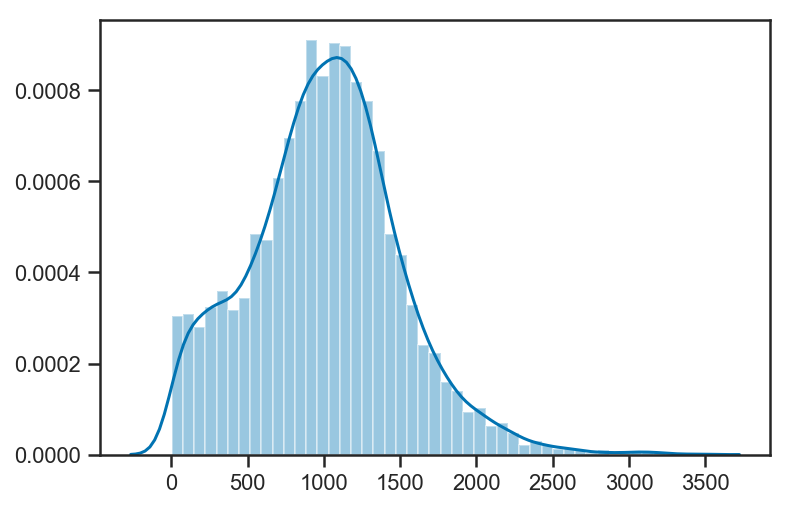

In [30]:
sns.distplot(lens)
print('I have {:d} objects with fewer than 30 samples'.format(count_nonzero(lens<=30)))

I chose 30 because 30 samples out of the 4000 posterior samples are required before a down-sampling to 128 samples will have just one "effective" sample in it.  This suggests why we are seeing biases with only 128 samples per event, and that we should actually have all 4000 (and maybe more---but let's start with 4000).

This suggests that we will need to move to some sort of likelihood function approximation in order to get good sampling (it is impractical to have thousands of samples to average over).